In [1]:
!pip install tf_keras_vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 4.6 MB/s eta 0:00:00


Setup and Data Loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path = '/content/drive/My Drive/Zalando_Fashion_Project/Zalando_Fashion_Dataset'

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import random
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam import GradcamPlusPlus
from tf_keras_vis.utils import normalize
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Define the input size for VGG19
IMG_SIZE = (224, 224)
BATCH_SIZE = 256

# Data augmentation and preprocessing
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Use VGG19's preprocessing
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

# Load training data
train_generator = datagen.flow_from_directory(
    '/content/drive/My Drive/Zalando_Fashion_Project/Zalando_Fashion_Dataset/Train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
)

# Load validation data
validation_generator = datagen.flow_from_directory(
    '/content/drive/My Drive/Zalando_Fashion_Project/Zalando_Fashion_Dataset/Train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
)

# Load and preprocess test images
test_generator = datagen.flow_from_directory(
    '/content/drive/My Drive/Zalando_Fashion_Project/Zalando_Fashion_Dataset/Test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

fashion_categories = ['hoodies', 'hoodies_female', 'longsleeve', 'shirt', 'sweatshirt', 'sweatshirt_female']

Mounted at /content/drive
Found 13121 images belonging to 6 classes.
Found 1455 images belonging to 6 classes.
Found 1624 images belonging to 6 classes.


Model Creation

In [3]:
# Create Precision and Recall metrics outside the function
precision_metric = Precision()
recall_metric = Recall()

# Custom F1-score metric
def f1_score(y_true, y_pred):
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    f1 = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
    return f1

# Apply mixed precision for faster training and less GPU load
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Load pre-trained VGG19 model without the top classification layer
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model to retain pre-trained weights
base_model.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(6, activation='softmax')(x)  # 6 classes for Zalando Fashion Dataset

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [4]:
# Calculate class weights
train_data_path = '/content/drive/My Drive/Zalando_Fashion_Project/Zalando_Fashion_Dataset/Train'
fashion_categories = ['hoodies', 'hoodies_female', 'longsleeve', 'shirt', 'sweatshirt', 'sweatshirt_female']
train_counts = {category: 0 for category in fashion_categories}

for category in fashion_categories:
    category_path = os.path.join(train_data_path, category)
    train_counts[category] = len(os.listdir(category_path))

total_samples = sum(train_counts.values())
class_weights = {i: total_samples / count for i, count in enumerate(train_counts.values())}
print(class_weights)

{0: 7.556246759979264, 1: 13.38475665748393, 2: 9.526797385620915, 3: 3.381118070053352, 4: 4.156258910749929, 5: 6.595475113122172}


In [5]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,290,118 (77.40 MB)

 Trainable params: 265,734 (1.01 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

Model Training and Evaluation

In [6]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), f1_score]
)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=70,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    class_weight=class_weights
)
# Evaluate the model and unpack the returned values appropriately
test_loss, test_accuracy, test_precision, test_recall, test_f1_score = model.evaluate(validation_generator)

# Print the test accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/70
51/51 ━━━━━━━━━━━━━━━━━━━━ 5290s 104s/step - accuracy: 0.1903 - f1_score: 0.1454 - loss: 29.4485 - precision: 0.1938 - recall: 0.1679 - val_accuracy: 0.5648 - val_f1_score: 0.2826 - val_loss: 1.0458 - val_precision: 0.7103 - val_recall: 0.3945
Epoch 2/70
 1/51 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.5234 - f1_score: 0.2931 - loss: 8.2571 - precision: 0.6131 - recall: 0.4023

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


51/51 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5234 - f1_score: 0.2931 - loss: 8.2571 - precision: 0.6131 - recall: 0.4023 - val_accuracy: 0.5633 - val_f1_score: 0.3019 - val_loss: 1.0339 - val_precision: 0.7028 - val_recall: 0.3750
Epoch 3/70
51/51 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - accuracy: 0.5137 - f1_score: 0.3314 - loss: 7.8648 - precision: 0.6642 - recall: 0.3764 - val_accuracy: 0.6219 - val_f1_score: 0.3903 - val_loss: 0.8792 - val_precision: 0.7580 - val_recall: 0.4062
Epoch 4/70
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 353ms/step - accuracy: 0.5664 - f1_score: 0.3934 - loss: 7.1087 - precision: 0.6887 - recall: 0.4062 - val_accuracy: 0.6156 - val_f1_score: 0.3967 - val_loss: 0.8932 - val_precision: 0.7580 - val_recall: 0.4086
Epoch 5/70
51/51 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - accuracy: 0.5751 - f1_score: 0.4111 - loss: 6.5808 - precision: 0.6995 - recall: 0.4292 - val_accuracy: 0.5820 - val_f1_score: 0.4366 - val_loss: 0.8884 - val_precision: 0.7351 - val_recall: 0.3945
Epoch 

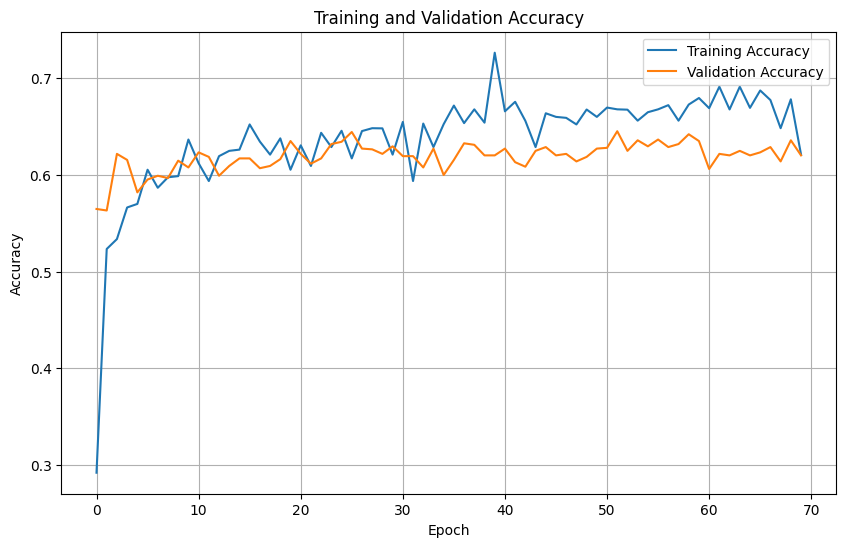

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()